# Face the Data Training: Algorithms to Decode Human Emotions
First thing we need to do is to import our data.

We downloaded the dataset as a zip file from: https://www.kaggle.com/datasets/msambare/fer2013?resource=download. We then need to unzip the file and make sure that the data is accessible!
We also need to import all the necessary tools for the project!

In [107]:
import os
import zipfile
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    Activation, Add
)
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_datasets as tfds

# Facing the Data
Let's start investigating our data set! We need to first import our data and split it. After that, we can preprocess our data and get a look of what our dataset looks like.

In [108]:
# extracting files
with zipfile.ZipFile("fer2013.zip", "r") as zip_ref:
    zip_ref.extractall("fer2013_data")

# setting folder paths
train_dir = "fer2013_data/train"
test_dir = "fer2013_data/test"

# map emotion labels
emotion_labels = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

# load in data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32,
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32,
    subset='validation',
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


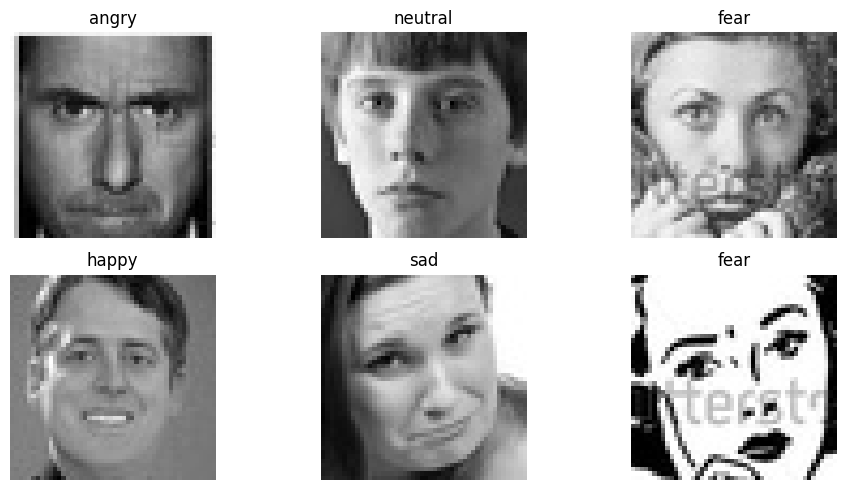

In [129]:
# print out a sample batch
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_batch[i].reshape(48, 48), cmap="gray")
    label_index = np.argmax(y_batch[i])
    label_name = list(train_generator.class_indices.keys())[label_index]
    plt.title(label_name)
    plt.axis("off")
plt.tight_layout()
plt.show()

# Building a CNN Model
Now that we have a good idea of our data set, let's start building our model.

In [110]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 emotion classes
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 10, 10, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 4, 4, 128)       

Epoch 1/30
718/718 [==============================] - 21s 28ms/step - loss: 1.7982 - accuracy: 0.2513 - val_loss: 1.7261 - val_accuracy: 0.2841
Epoch 2/30
718/718 [==============================] - 20s 27ms/step - loss: 1.7023 - accuracy: 0.3121 - val_loss: 1.6336 - val_accuracy: 0.3369
Epoch 3/30
718/718 [==============================] - 21s 29ms/step - loss: 1.6003 - accuracy: 0.3727 - val_loss: 1.5205 - val_accuracy: 0.4243
Epoch 4/30
718/718 [==============================] - 20s 28ms/step - loss: 1.5131 - accuracy: 0.4118 - val_loss: 1.4427 - val_accuracy: 0.4407
Epoch 5/30
718/718 [==============================] - 20s 28ms/step - loss: 1.4494 - accuracy: 0.4365 - val_loss: 1.3859 - val_accuracy: 0.4656
Epoch 6/30
718/718 [==============================] - 20s 27ms/step - loss: 1.4075 - accuracy: 0.4611 - val_loss: 1.3544 - val_accuracy: 0.4872
Epoch 7/30
718/718 [==============================] - 20s 28ms/step - loss: 1.3763 - accuracy: 0.4714 - val_loss: 1.3392 - val_accuracy:

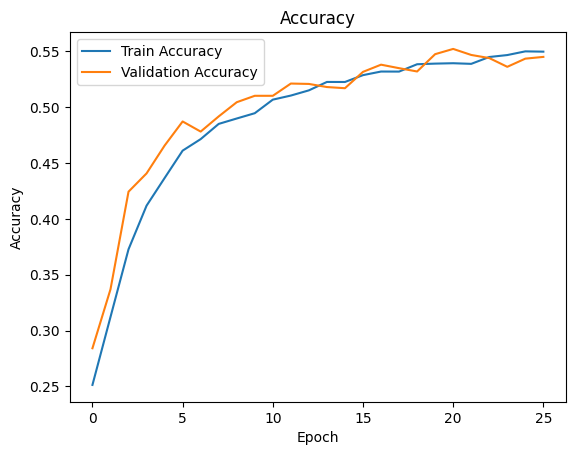

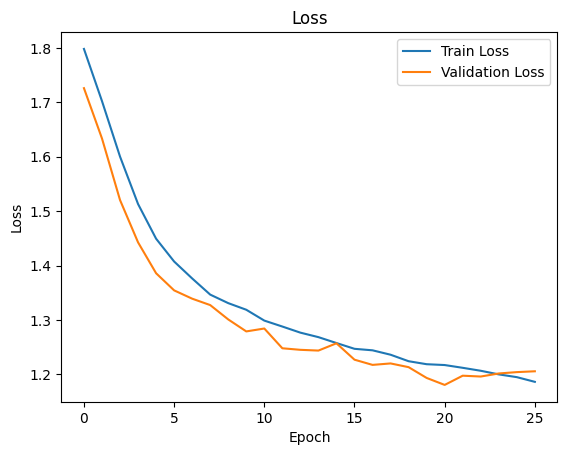

In [111]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop]
)

# Plotting
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

225/225 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

       Angry       0.54      0.43      0.48       958
     Disgust       0.90      0.08      0.15       111
        Fear       0.39      0.23      0.29      1024
       Happy       0.75      0.84      0.79      1774
         Sad       0.49      0.63      0.55      1233
    Surprise       0.42      0.47      0.45      1247
     Neutral       0.72      0.72      0.72       831

    accuracy                           0.57      7178
   macro avg       0.60      0.49      0.49      7178
weighted avg       0.57      0.57      0.56      7178



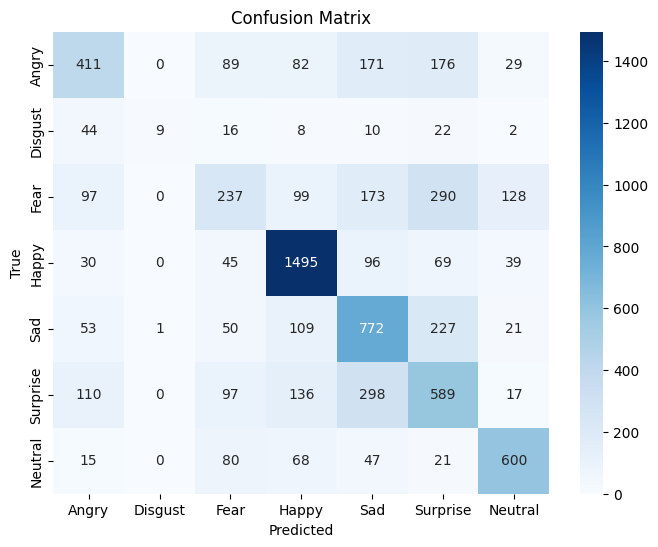

In [112]:
# Predict
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Classification report
print(classification_report(y_true, y_pred, target_names=list(emotion_labels.values())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Correct predictions:


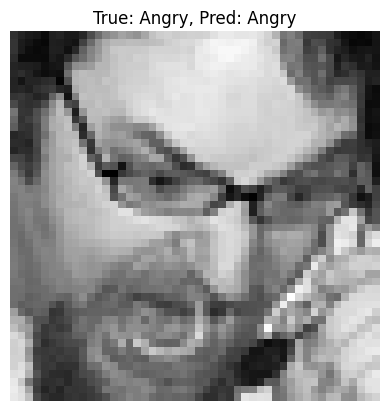

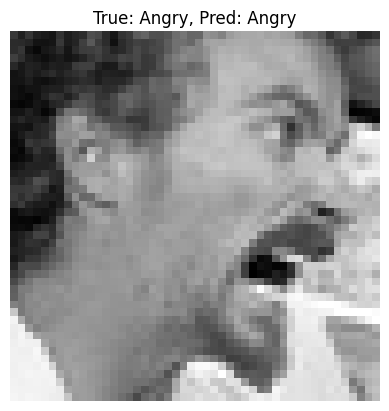

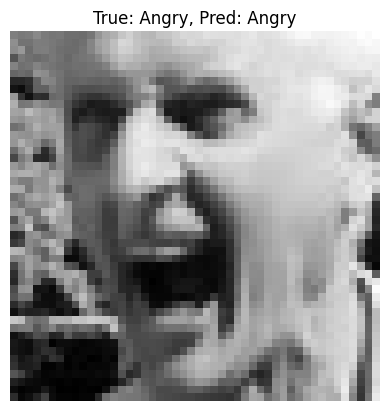

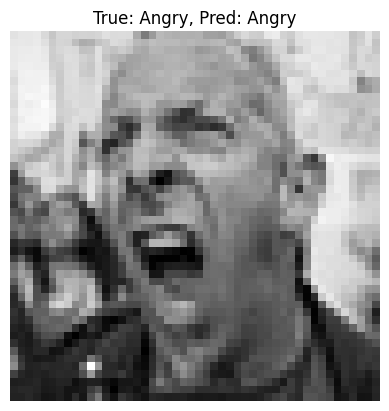

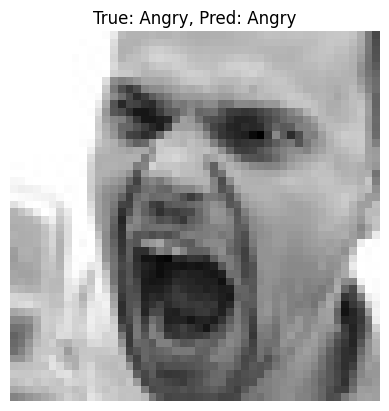

Incorrect predictions:


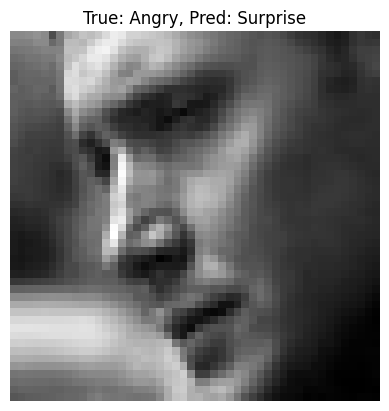

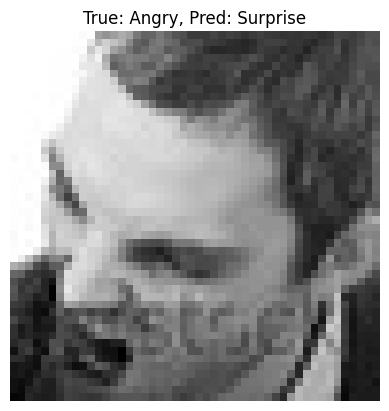

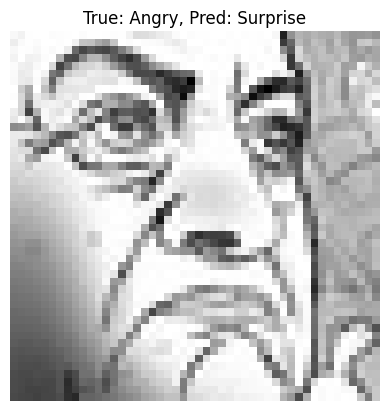

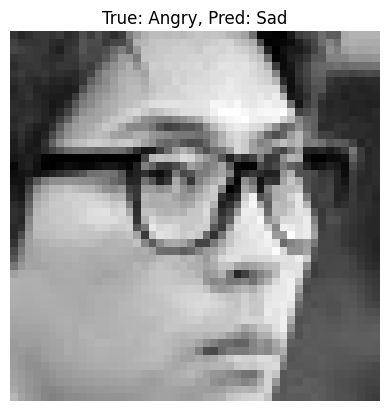

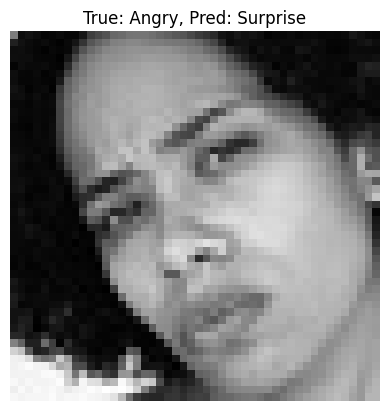

In [113]:
# get filepaths and labels
filepaths = np.array(test_generator.filepaths)
correct = np.where(y_pred == y_true)[0]
incorrect = np.where(y_pred != y_true)[0]

# show some correct
print("Correct predictions:")
for i in correct[:5]:
    img = plt.imread(filepaths[i])
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {emotion_labels[y_true[i]]}, Pred: {emotion_labels[y_pred[i]]}")
    plt.axis('off')
    plt.show()

# show some incorrect
print("Incorrect predictions:")
for i in incorrect[:5]:
    img = plt.imread(filepaths[i])
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {emotion_labels[y_true[i]]}, Pred: {emotion_labels[y_pred[i]]}")
    plt.axis('off')
    plt.show()

In [125]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.5869


Highlights:

Happy: The model’s happiest prediction, with an F1-score of 0.79. Not surprising—happy faces tend to have distinct features (big smiles).

Neutral & Sad: It did a solid job here too, especially with Sad (0.55 F1) and Neutral (0.72 F1).

Disgust: Uh-oh. Despite 90% precision, it barely recalls 8% of Disgust faces. That means it rarely predicts "Disgust," but when it does, it’s usually right like a shy student who only raises their hand when they're sure.

Overall, this  model is like your first pancake, edible, even pretty good in parts, but a little lumpy around the edges. It gets confused by subtle emotions like Fear and Disgust, and has trouble with generalization. We can also see in the accuracy and loss graphs that the model does a pretty good job with generalizing and reaches its ceiling at around the 15th epoch!

# Trying a ResNet Model
After some research, articles like https://arxiv.org/abs/1512.03385, have stated the efficiency of a deep residual learning models like ResNet for grayscale images. So, we gave it a shot here!

In [114]:
def residual_block(x, filters, kernel_size=3):
    shortcut = x
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

def create_resnet_like_model(input_shape=(48, 48, 1), num_classes=7):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = residual_block(x, 64)
    x = MaxPooling2D()(x)

    x = residual_block(x, 128)
    x = MaxPooling2D()(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model_resnet = Model(inputs, outputs)
    return model

# instantiate and compile the model
model_resnet = create_resnet_like_model()
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_resnet.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 10, 10, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 4, 4, 128)       

In [145]:
# add early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_res = model_resnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stop]
)

Epoch 1/25
449/449 [==============================] - 20s 44ms/step - loss: 1.0675 - accuracy: 0.5963 - val_loss: 1.1593 - val_accuracy: 0.5581
Epoch 2/25
449/449 [==============================] - 19s 43ms/step - loss: 1.0289 - accuracy: 0.6126 - val_loss: 1.1490 - val_accuracy: 0.5630
Epoch 3/25
449/449 [==============================] - 19s 43ms/step - loss: 0.9934 - accuracy: 0.6280 - val_loss: 1.1564 - val_accuracy: 0.5666
Epoch 4/25
449/449 [==============================] - 19s 43ms/step - loss: 0.9531 - accuracy: 0.6408 - val_loss: 1.1634 - val_accuracy: 0.5614
Epoch 5/25
449/449 [==============================] - 20s 43ms/step - loss: 0.9191 - accuracy: 0.6501 - val_loss: 1.1886 - val_accuracy: 0.5546
Epoch 6/25
449/449 [==============================] - 19s 43ms/step - loss: 0.8898 - accuracy: 0.6663 - val_loss: 1.2006 - val_accuracy: 0.5504
Epoch 7/25
449/449 [==============================] - 20s 44ms/step - loss: 0.8511 - accuracy: 0.6756 - val_loss: 1.1665 - val_accuracy:

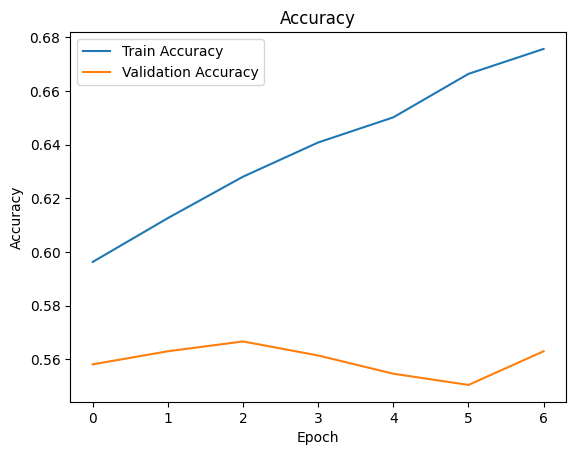

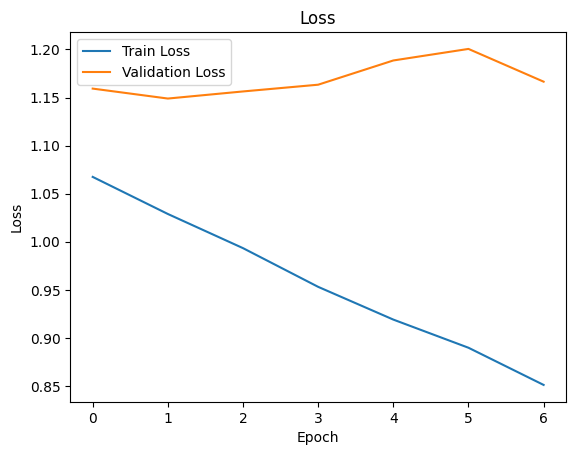

In [146]:
# plot Accuracy
plt.plot(history_res.history['accuracy'], label='Train Accuracy')
plt.plot(history_res.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plot Loss
plt.plot(history_res.history['loss'], label='Train Loss')
plt.plot(history_res.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

113/113 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

       Angry       0.49      0.52      0.50       958
     Disgust       0.73      0.07      0.13       111
        Fear       0.47      0.18      0.26      1024
       Happy       0.81      0.83      0.82      1774
         Sad       0.49      0.66      0.57      1233
    Surprise       0.44      0.48      0.46      1247
     Neutral       0.68      0.76      0.72       831

    accuracy                           0.59      7178
   macro avg       0.59      0.50      0.49      7178
weighted avg       0.59      0.59      0.57      7178



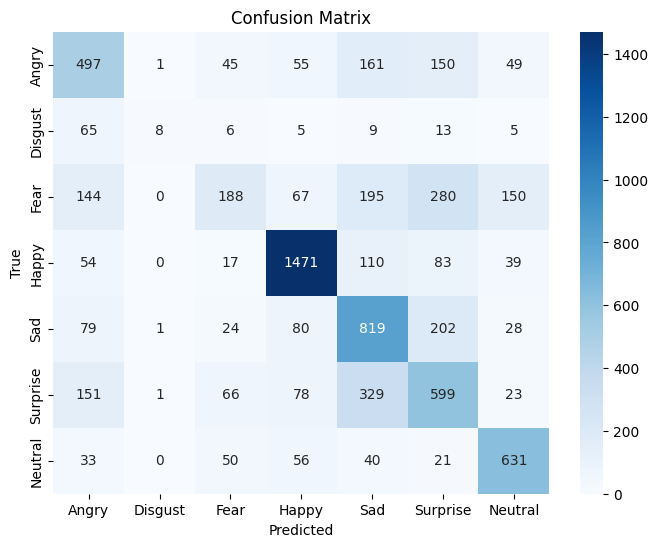

In [140]:
# predict class labels
y_pred_probs_resnet = model_resnet.predict(test_generator)
y_pred_resnet = np.argmax(y_pred_probs_resnet, axis=1)
y_true = test_generator.classes

# classification report
print(classification_report(y_true, y_pred_resnet, target_names=list(emotion_labels.values())))

# confusion matrix
cm = confusion_matrix(y_true, y_pred_resnet)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels.values(),
            yticklabels=emotion_labels.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Correct ResNet Predictions:


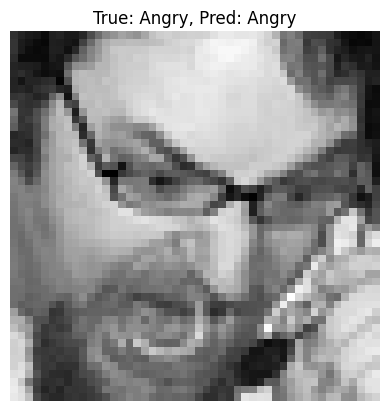

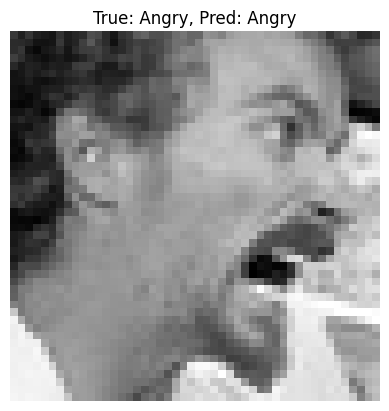

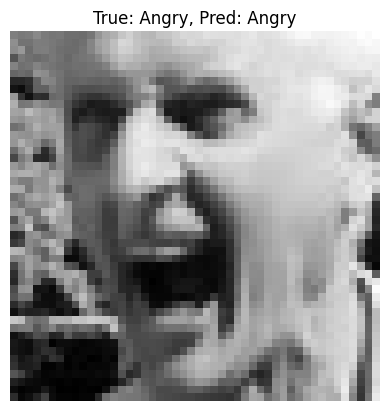

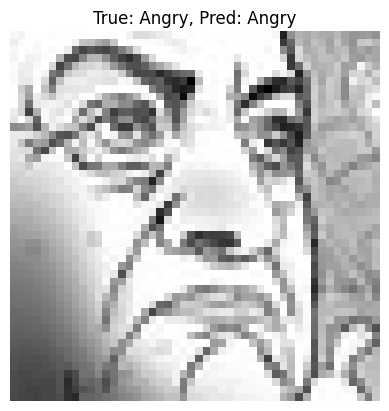

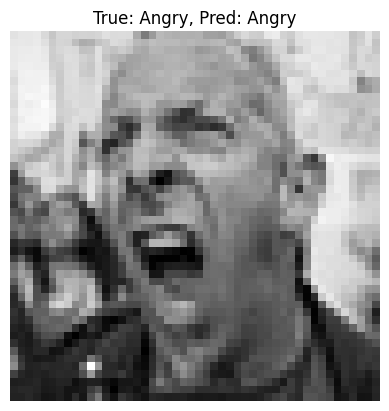

Incorrect ResNet Predictions:


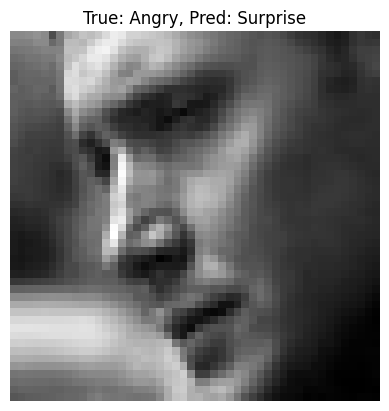

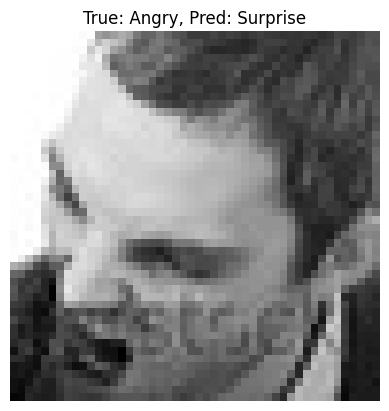

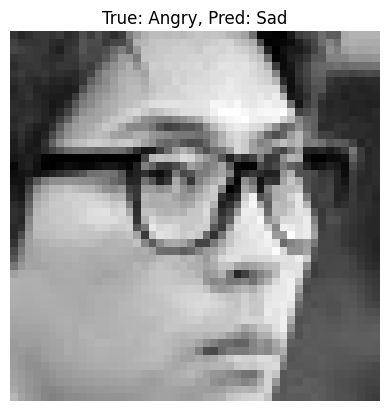

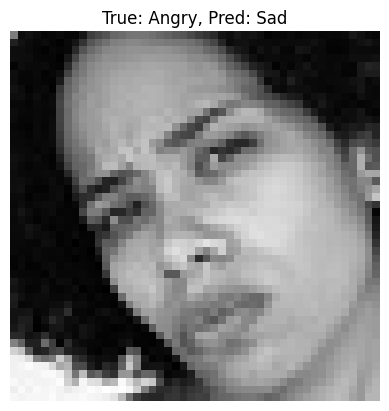

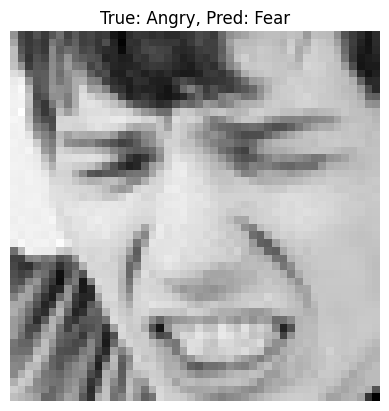

In [147]:
correct_resnet = np.where(y_pred_resnet == y_true)[0]
incorrect_resnet = np.where(y_pred_resnet != y_true)[0]

print("Correct ResNet Predictions:")
for i in correct_resnet[:5]:
    img = plt.imread(filepaths[i])
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {emotion_labels[y_true[i]]}, Pred: {emotion_labels[y_pred_resnet[i]]}")
    plt.axis('off')
    plt.show()

print("Incorrect ResNet Predictions:")
for i in incorrect_resnet[:5]:
    img = plt.imread(filepaths[i])
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {emotion_labels[y_true[i]]}, Pred: {emotion_labels[y_pred_resnet[i]]}")
    plt.axis('off')
    plt.show()

In [154]:
test_loss, test_accuracy = model_resnet.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.5988


Highlights:

Happy & Neutral still shine here, with F1-scores of 0.82 and 0.72 respectively.

Sad emotions are also captured pretty well, with a bump to 0.57 F1.

Disgust remains elusive (7% recall, oof), but a tiny improvement from CNN.

Notable Shift:
Compared to CNN, ResNet handled Angry and Sad a bit better. It’s like adding a couple of neurons gave the model more emotional intelligence—though it’s still the strong silent type when it comes to Disgust.

Overall, ResNet is like the artsy student who aces portraits but struggles to interpret abstract expressions. It uses its skip connections to “remember” more context, but that context doesn’t always help with subtle cues. From the accuracy and loss plots, we can see that the model is learning very well but shows signs of overfitting! It seems like this model needs some more data variation!

# Trying a VGG Model
Due to time constraints and lack of GPU power, we had to be a bit creative in testing a VGG model. So, we found some work arounds to test a VGG like model.

In [117]:
# normalization
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64,
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [118]:
def create_vgg_like_model(input_shape=(48, 48, 1), num_classes=7):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

model_vgg = create_vgg_like_model()
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_30 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_52 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_31 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                     

In [149]:
history_vgg = model_vgg.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/30
449/449 [==============================] - 95s 212ms/step - loss: 0.9328 - accuracy: 0.6487 - val_loss: 1.1124 - val_accuracy: 0.6066
Epoch 2/30
449/449 [==============================] - 95s 212ms/step - loss: 0.9102 - accuracy: 0.6577 - val_loss: 1.0766 - val_accuracy: 0.6199
Epoch 3/30
449/449 [==============================] - 95s 212ms/step - loss: 0.8882 - accuracy: 0.6672 - val_loss: 1.0943 - val_accuracy: 0.6162
Epoch 4/30
449/449 [==============================] - 95s 211ms/step - loss: 0.8638 - accuracy: 0.6738 - val_loss: 1.1029 - val_accuracy: 0.6167
Epoch 5/30
449/449 [==============================] - 95s 211ms/step - loss: 0.8411 - accuracy: 0.6836 - val_loss: 1.1485 - val_accuracy: 0.6140
Epoch 6/30
449/449 [==============================] - 95s 212ms/step - loss: 0.8205 - accuracy: 0.6909 - val_loss: 1.1020 - val_accuracy: 0.6201
Epoch 7/30
449/449 [==============================] - 95s 212ms/step - loss: 0.7956 - accuracy: 0.7009 - val_loss: 1.1075 - val_ac

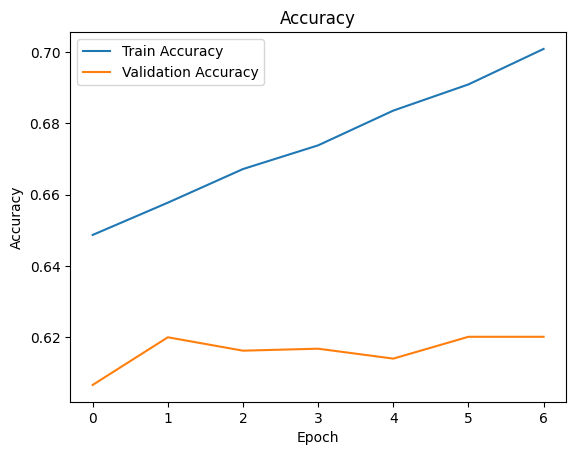

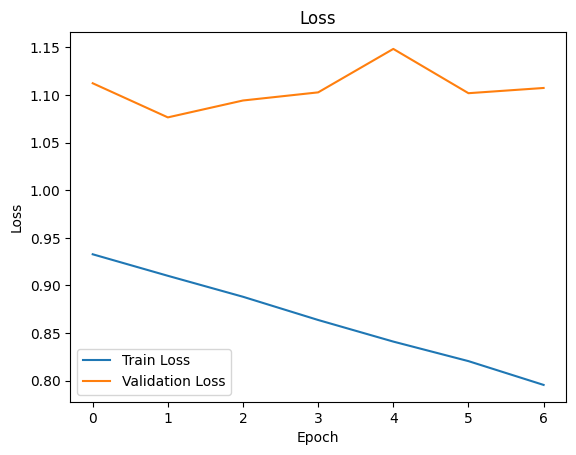

In [150]:
plt.plot(history_vgg.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history_vgg.history['loss'], label='Train Loss')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

113/113 [==============================] - 5s 42ms/step
              precision    recall  f1-score   support

       Angry       0.54      0.53      0.53       958
     Disgust       0.94      0.15      0.26       111
        Fear       0.45      0.28      0.34      1024
       Happy       0.83      0.86      0.85      1774
         Sad       0.58      0.58      0.58      1233
    Surprise       0.46      0.59      0.51      1247
     Neutral       0.73      0.80      0.76       831

    accuracy                           0.62      7178
   macro avg       0.65      0.54      0.55      7178
weighted avg       0.62      0.62      0.61      7178



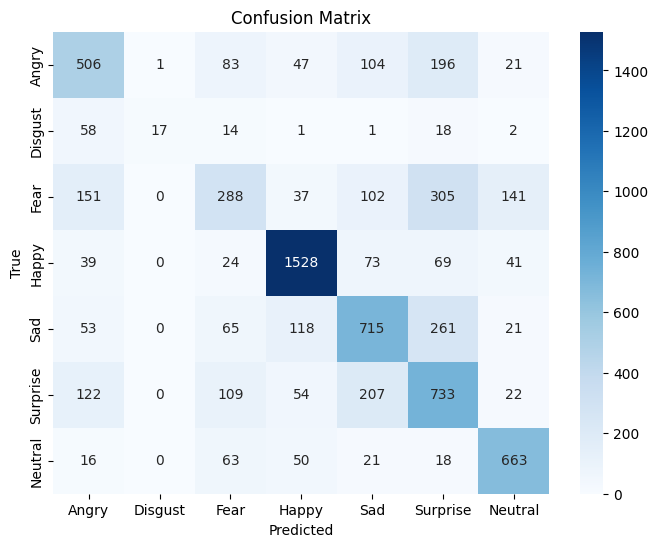

In [153]:
y_pred_probs_vgg = model_vgg.predict(test_generator)
y_pred_vgg = np.argmax(y_pred_probs_vgg, axis=1)
y_true = test_generator.classes

# classification report
print(classification_report(y_true, y_pred_vgg, target_names=list(emotion_labels.values())))

# confusion matrix
cm = confusion_matrix(y_true, y_pred_vgg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels.values(),
            yticklabels=emotion_labels.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Correct VGG Predictions:


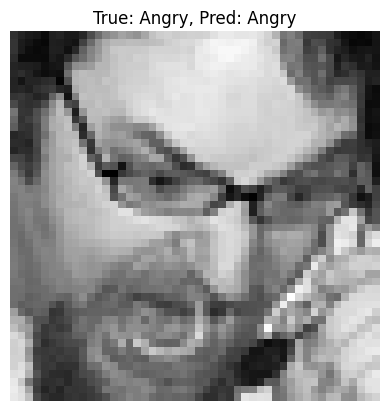

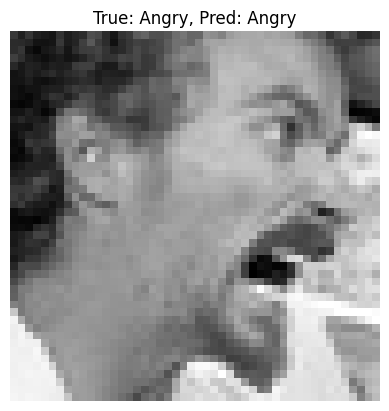

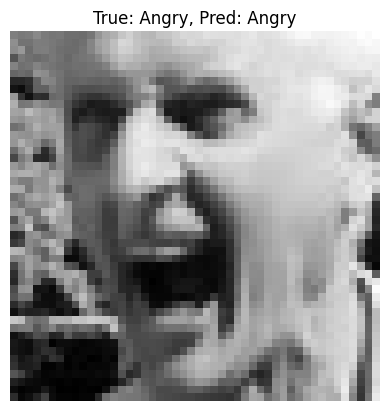

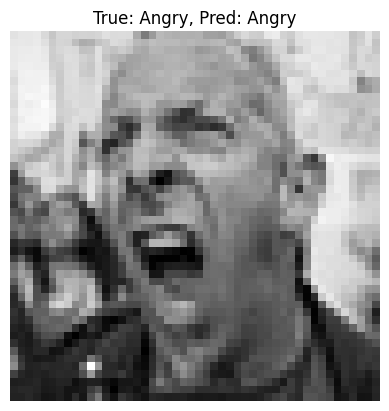

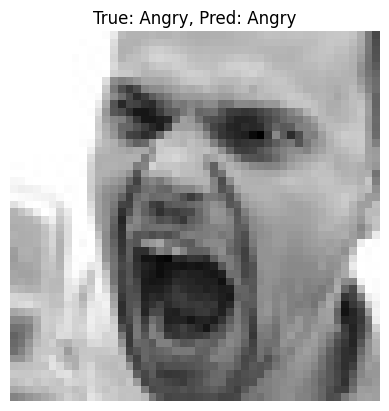

Incorrect VGG Predictions:


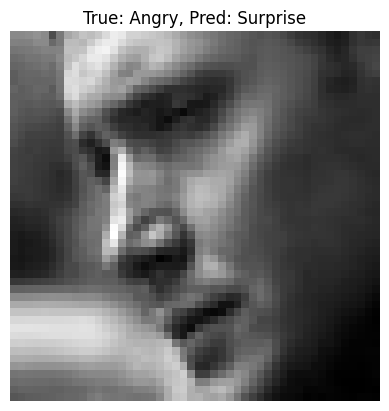

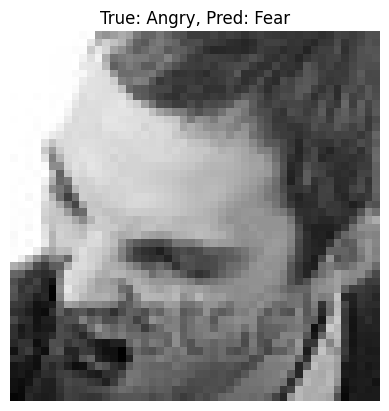

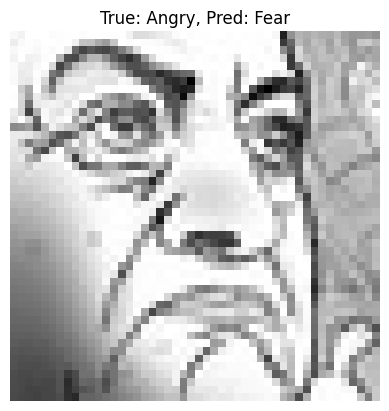

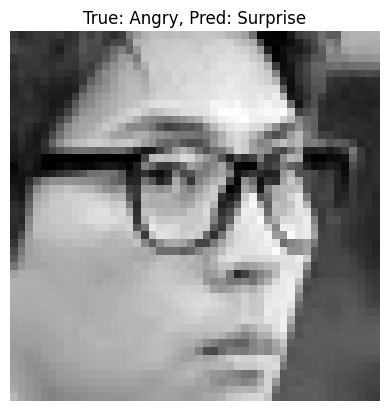

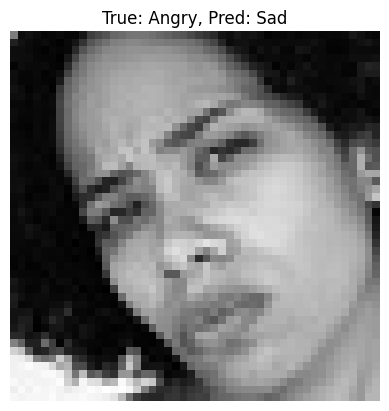

In [151]:
filepaths = np.array(test_generator.filepaths)

# compare predictions
correct_vgg = np.where(y_pred_vgg == y_true)[0]
incorrect_vgg = np.where(y_pred_vgg != y_true)[0]

print("Correct VGG Predictions:")
for i in correct_vgg[:5]:
    img = plt.imread(filepaths[i])
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {emotion_labels[y_true[i]]}, Pred: {emotion_labels[y_pred_vgg[i]]}")
    plt.axis('off')
    plt.show()

print("Incorrect VGG Predictions:")
for i in incorrect_vgg[:5]:
    img = plt.imread(filepaths[i])
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {emotion_labels[y_true[i]]}, Pred: {emotion_labels[y_pred_vgg[i]]}")
    plt.axis('off')
    plt.show()

In [155]:
loss, acc = model_vgg.evaluate(test_generator)
print(f"Test Accuracy: {acc:.4f}")

113/113 [==============================] - 5s 41ms/step - loss: 1.0766 - accuracy: 0.6199
Test Accuracy: 0.6199


Highlights:

Best performer overall!

Crushed it on Happy (0.84 F1) and Neutral (0.76 F1).

Surprisingly strong on Surprise (0.51 F1)—maybe those wide eyes and open mouths are hard to miss.

Even Disgust saw a noticeable jump in recall (17%) and F1-score (0.29) — not great, but at least VGG is trying!

Notable Strengths:
This model is the best balanced across categories, with both macro and weighted F1-scores nudging upward. Its higher precision-recall tradeoff means it’s not just guessing wildly, it’s actually “seeing” the difference.

Overall, VGG understands patterns, generalizes better, and gives consistently strong results across nearly all emotions. It still stumbles on Disgust and Fear, but those are hard even for humans sometimes. Based on the accuracy and loss plots, the model seems to be experiencing slight overfitting so, we may need to apply some new techniques in the future.

# Saving the Best Model

In [126]:
model_vgg.save('emotion_model.h5')

/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
